# Megamean Visualizations

In this notebook, we will look at visualizations of the connectome megameans for diffusion and functional MRI-derived connectomes.

The graphs were constructed as follows:

## Diffusion

DWI connectomes were acquired from 2,861 scans from approximately 1,613 subjects across 12 scanning sites for the desikan parcellation using the NDMG-d pipeline. Connectome statistics were performed by taking the edge-wise mean fiber count over all connectomes in the cohort, and reporting the resulting graph as the "megamean" diffusion connectome.

## Functional

fMRI connectomes were acquired from 1,709 scans from approximately 813 subjects across 18 scanning sites for the desikan parcellation using the NDMG-f pipeline. Connectome statistics were performed by taking the edge-wise mean fiber count over all connectomes in the cohort, and reporting the resulting graph as the "megamean" fMRI connectome.

## Parcellation

The results shown are connectomes computed over the desikan parcellation. The first 35 ROIs represent the left-hemisphere vertices, and the second 35 ROIs represent the right-hemisphere vertices. 

# Plots

For our visualizations, we visualize the graphs as an adjacency matrix in which the regions of interest (ROIs) are ordered by hemisphere.

## Adjacency Matrix

In this canonical plot, we visualize the adjacency matrix as a heat-map, where edge-intensities are reported as the color in the plot.

## Graph Plot

In this plot, we visualize the adjacency matrix as a 

## Connectome Plot

In this plot, we visualize the graph ROIs overlaid with the MNI152 brain. The ROIs are connected by edges representing the edge-weights in the connectomes.

In [104]:
%matplotlib inline
import networkx as nx
import nilearn as ni
import numpy as np
import nibabel as nb
from nilearn import plotting as nip
from nilearn import image
from nilearn import input_data
from nilearn.regions import connected_label_regions
import matplotlib.pyplot as plt

In [185]:
dwi_megamean_graph = nx.read_weighted_edgelist('./data/dwimean_2861.edgelist')
nodes = dwi_megamean_graph.nodes()
sort_id = np.argsort(np.array(nodes).astype(int))
sorted_nodes = np.array(nodes)[sort_id]
dwi_megamean_mtx = nx.to_numpy_matrix(dwi_megamean_graph, nodelist=sorted_nodes)
fmri_megamean_graph = nx.read_weighted_edgelist('./data/fmrimean_1709.edgelist')
fmri_megamean_mtx = nx.to_numpy_matrix(fmri_megamean_graph, nodelist=sorted_nodes)

We begin by visualizing the desikan parcellation:

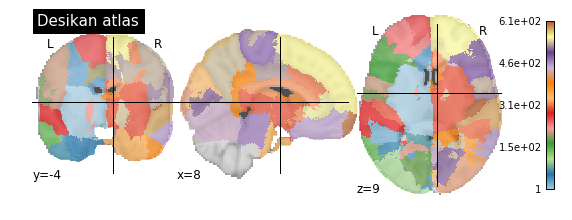

In [186]:
from nilearn import datasets
from nilearn.regions import connected_label_regions

des = './data/desikan_res-1x1x1.nii.gz'
desim = nb.load(des)
desim = nb.Nifti1Image(affine=desim.affine, header=desim.header, dataobj=desim.get_data())

reg = connected_label_regions(desim)
nip.plot_roi(reg, title='Desikan atlas',
            cut_coords=(8, -4, 9), colorbar=True, cmap='Paired')

In [187]:
des_dat = desim.get_data()
labs = np.unique(des_dat)
labs = labs[labs != 0]
des_4ddat = np.stack([np.asarray(des_dat == lab).astype('float64') for lab in labs], axis=3)
des_parcels = nb.Nifti1Image(dataobj=des_4ddat, header=desim.header, affine=desim.affine)

First, we calculate the 3d coordinates of our ROIs:

In [188]:
regions_imgs = image.iter_img(des_parcels)
coords_connectome = [nip.find_xyz_cut_coords(img) for img in regions_imgs]

# Diffusion Connectome

## Adjacency Matrix

We can look at the diffusion connectome as an adjacency matrix:

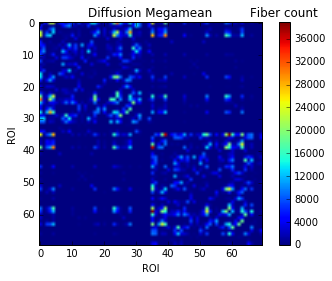

In [201]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(dwi_megamean_mtx)
ax.set_xlabel('ROI')
ax.set_ylabel('ROI')
ax.set_title('Diffusion Megamean')
cbar = fig.colorbar(cax)
cbar.ax.set_title('Fiber count')

## Coronal Projection

Below, we threshold the top $80%$ of edges, and visualize the 2-d projection of the adjacency graph in a coronal slice in real brain space (where position is determined by location of the ROI in the MNI152 template atlas). We visualize the top $80%$ of edges, the top $80%$ of edges within hemisphere (ie, only edges that are from left hemisphere to left hemisphere, or right hemisphere to right hemisphere), and the top $80%$ of edges across hemisphere (ie, only edges that are from left hemisphere to right hemisphere, and vice versa):

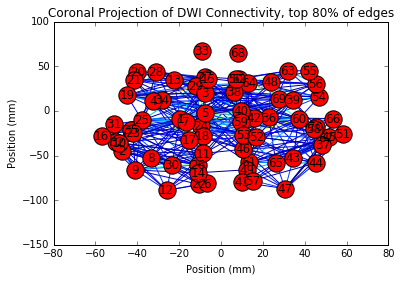

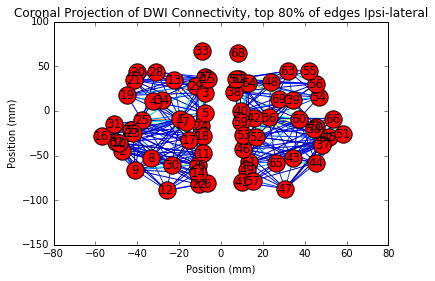

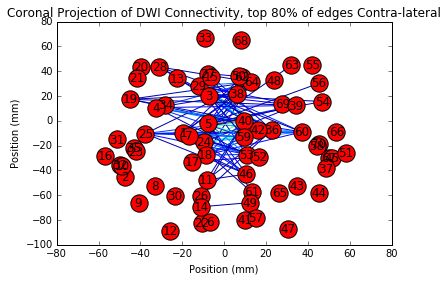

In [202]:
import copy
coords = {}
for lab, coord in zip(sorted_nodes, coords_connectome):
    coords[lab] = coord[:2]
dwi = copy.deepcopy(dwi_megamean_graph)
for u, v, d in dwi.edges(data='weight'):
    if d < np.percentile(dwi_megamean_mtx, 80):
        dwi.remove_edge(u, v)
        
edges = [d for u, v, d in dwi.edges(data='weight')]
cmap = plt.cm.Purples
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
nx.draw_networkx(dwi, ax=ax, pos=coords, cmap=my_cmap, edge_color=edges, edge_vmin=0, edge_vmax=np.max(dwi_megamean_mtx))
ax.set_xlabel('Position (mm)')
ax.set_ylabel('Position (mm)')
ax.set_title('Coronal Projection of DWI Connectivity, top 80% of edges')
fig.show()

dwi = copy.deepcopy(dwi_megamean_graph)
for u, v, d in dwi.edges(data='weight'):
    if d < np.percentile(dwi_megamean_mtx, 80) or ((int(u) <= 35 and int(v) > 35) or (int(u) > 35 and int(v) <= 35)):
        dwi.remove_edge(u, v)
        
edges = [d for u, v, d in dwi.edges(data='weight')]
cmap = plt.cm.Purples
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
nx.draw_networkx(dwi, ax=ax, pos=coords, cmap=my_cmap, edge_color=edges, edge_vmin=0, edge_vmax=np.max(dwi_megamean_mtx))
ax.set_xlabel('Position (mm)')
ax.set_ylabel('Position (mm)')
ax.set_title('Coronal Projection of DWI Connectivity, top 80% of edges Ipsi-lateral')
fig.show()

dwi = copy.deepcopy(dwi_megamean_graph)
for u, v, d in dwi.edges(data='weight'):
    if d < np.percentile(dwi_megamean_mtx, 80) or ((int(u) <= 35 and int(v) <= 35) or (int(u) > 35 and int(v) > 35)):
        dwi.remove_edge(u, v)
        
edges = [d for u, v, d in dwi.edges(data='weight')]
cmap = plt.cm.Purples
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
nx.draw_networkx(dwi, ax=ax, pos=coords, cmap=my_cmap, edge_color=edges, edge_vmin=0, edge_vmax=np.max(dwi_megamean_mtx))
ax.set_xlabel('Position (mm)')
ax.set_ylabel('Position (mm)')
ax.set_title('Coronal Projection of DWI Connectivity, top 80% of edges Contra-lateral')
fig.show()

It is clear that the majority of the top $80%$ of edges occur ipsi-laterally, and contra-lateral connections are mainly prevalent between regions directly adjacent the corpus callosum. This intuitively makes sense in the structural DWI connectomes.

# Functional Connectome

## Adjacency Matrix

We can look at the functional connectome as an adjacency matrix:

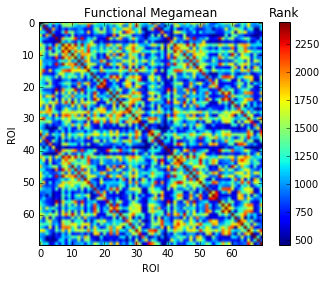

In [204]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(fmri_megamean_mtx)
ax.set_xlabel('ROI')
ax.set_ylabel('ROI')
ax.set_title('Functional Megamean')
cbar = fig.colorbar(cax)
cbar.ax.set_title('Rank')

## Coronal Projection

We repeat the same process as above to visualize the functional connectome as a graph, retaining the top-$80%$ of edges in our 3 coronal sections:

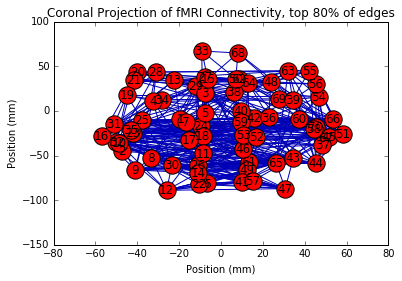

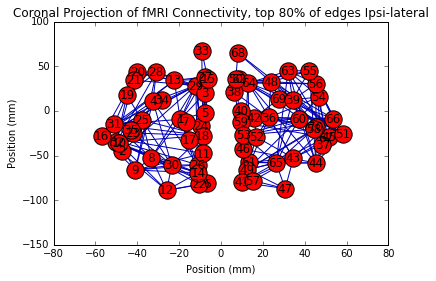

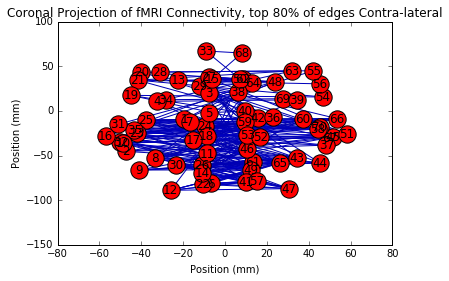

In [206]:
import copy
coords = {}
for lab, coord in zip(sorted_nodes, coords_connectome):
    coords[lab] = coord[:2]
fmri = copy.deepcopy(fmri_megamean_graph)
for u, v, d in fmri.edges(data='weight'):
    if d < np.percentile(fmri_megamean_mtx, 80):
        fmri.remove_edge(u, v)
        
edges = [d for u, v, d in fmri.edges(data='weight')]
cmap = plt.cm.Purples
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
nx.draw_networkx(fmri, ax=ax, pos=coords, cmap=my_cmap, edge_color=edges, edge_vmin=0, edge_vmax=np.max(dwi_megamean_mtx))
ax.set_xlabel('Position (mm)')
ax.set_ylabel('Position (mm)')
ax.set_title('Coronal Projection of fMRI Connectivity, top 80% of edges')
fig.show()

fmri = copy.deepcopy(fmri_megamean_graph)
for u, v, d in fmri.edges(data='weight'):
    if d < np.percentile(fmri_megamean_mtx, 80) or ((int(u) <= 35 and int(v) > 35) or (int(u) > 35 and int(v) <= 35)):
        fmri.remove_edge(u, v)
        
edges = [d for u, v, d in fmri.edges(data='weight')]
cmap = plt.cm.Purples
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
nx.draw_networkx(fmri, ax=ax, pos=coords, cmap=my_cmap, edge_color=edges, edge_vmin=0, edge_vmax=np.max(dwi_megamean_mtx))
ax.set_xlabel('Position (mm)')
ax.set_ylabel('Position (mm)')
ax.set_title('Coronal Projection of fMRI Connectivity, top 80% of edges Ipsi-lateral')
fig.show()

fmri = copy.deepcopy(fmri_megamean_graph)
for u, v, d in fmri.edges(data='weight'):
    if d < np.percentile(fmri_megamean_mtx, 80) or ((int(u) <= 35 and int(v) <= 35) or (int(u) > 35 and int(v) > 35)):
        fmri.remove_edge(u, v)
        
edges = [d for u, v, d in fmri.edges(data='weight')]
cmap = plt.cm.Purples
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
nx.draw_networkx(fmri, ax=ax, pos=coords, cmap=my_cmap, edge_color=edges, edge_vmin=0, edge_vmax=np.max(dwi_megamean_mtx))
ax.set_xlabel('Position (mm)')
ax.set_ylabel('Position (mm)')
ax.set_title('Coronal Projection of fMRI Connectivity, top 80% of edges Contra-lateral')
fig.show()

As we can see, compared to the diffusion connectomes, the functional connectomes exhibit far less hemispheric separation. That is, there are more contra-lateral connections (across the left and right hemisphere) than 